In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#### Load Result Files of all Models

In [3]:
results_dict = {}

folder_path = "../energy_forecasting/results"

if os.path.exists(folder_path) and os.path.isdir(folder_path):
    for file_name in os.listdir(folder_path):
        if file_name.endswith(".csv"):
            file_path = os.path.join(folder_path, file_name)
            try:
                df = pd.read_csv(file_path, parse_dates=["Datetime"], index_col="Datetime")
                df.index = pd.to_datetime(df.index, utc=True)
                df.index = df.index.tz_convert('Europe/Berlin')
                
                results_dict[file_name[:-4]] = df
            except Exception as e:
                print(f"Error {file_name}: {e}")
else:
    print("Empty")

for key, value in results_dict.items():
    print(f"{key}: {value.shape}")

Baseline Forecast: (8736, 6)
LightGBM: (8736, 6)
Mean Ensemble: (8736, 6)
Median Ensemble: (8736, 6)
Quantile Regression: (8736, 6)
RF Quantile Regression: (8736, 6)
XGBoost: (8736, 6)


#### Filter Horizons

In [4]:

# Target-Horizons 
target_horizons = [
    {"dayofweek": 4, "hour": 12, "horizon": "36"},  # Freitag 12:00 Stunde: 36 
    {"dayofweek": 4, "hour": 16, "horizon": "40"},  # Freitag 16:00 Stunde: 40
    {"dayofweek": 4, "hour": 20, "horizon": "44"},  # Freitag 20:00 Stunde: 44
    {"dayofweek": 5, "hour": 12, "horizon": "60"},  # Samstag 12:00 Stunde: 60
    {"dayofweek": 5, "hour": 16, "horizon": "64"},  # Samstag 16:00 Stunde: 64
    {"dayofweek": 5, "hour": 20, "horizon": "68"},  # Samstag 20:00 Stunde: 68
]

# Filter target horizons
for key, df in results_dict.items():
    if not isinstance(df.index, pd.DatetimeIndex):
        df.index = pd.to_datetime(df.index)

    df["dayofweek"] = df.index.dayofweek
    df["hour"] = df.index.hour

    filtered_df = pd.DataFrame()

    for mapping in target_horizons:
        day = mapping["dayofweek"]
        hour = mapping["hour"]
        horizon = mapping["horizon"]

        subset = df[(df["dayofweek"] == day) & (df["hour"] == hour)].copy()
        subset["horizon"] = horizon

        filtered_df = pd.concat([filtered_df, subset])
        filtered_df = filtered_df.drop(columns=["dayofweek", "hour"])

    results_dict[key] = filtered_df

for key, value in results_dict.items():
    print(f"{key}: {value.shape}")


Baseline Forecast: (312, 7)
LightGBM: (312, 7)
Mean Ensemble: (312, 7)
Median Ensemble: (312, 7)
Quantile Regression: (312, 7)
RF Quantile Regression: (312, 7)
XGBoost: (312, 7)


#### Quantile Loss Overview

In [5]:
# Quantile Loss
quantile_loss_dict = {}
for key, df in results_dict.items():
    quantiles = [col for col in df.columns if col.startswith("q")]
    target = df["target"].values

    loss_df = df.copy()

    for q_col in quantiles:
        q = float(q_col[1:])
        y_pred = df[q_col].values
        loss = np.where(y_pred > target, 
                         (1 - q) * (y_pred - target), 
                          q * (target - y_pred))
        loss_df[q_col] = loss

    quantile_loss_dict[key] = loss_df

In [6]:
summary_rows = []

for model_name, loss_df in quantile_loss_dict.items():
    quantile_cols = [col for col in loss_df.columns if col.startswith("q")]
    
    avg_losses = loss_df[quantile_cols].mean()
    
    total_loss = avg_losses.sum()
    
    row = avg_losses.to_dict()
    row['Total Average Loss'] = total_loss
    row['Model'] = model_name
    
    summary_rows.append(row)

summary_df = pd.DataFrame(summary_rows)
summary_df = summary_df.set_index('Model')
summary_df = summary_df[sorted([col for col in summary_df.columns if col.startswith("q")]) + ['Total Average Loss']]

summary_df = summary_df.sort_values(by='Total Average Loss', ascending=False)

summary_df = summary_df.round(2)

In [7]:
summary_df

,q0.025,q0.25,q0.5,q0.75,q0.975,Total Average Loss
Model,,,,,,
Baseline Forecast,0.66,1.12,1.24,1.01,0.47,4.50
Quantile Regression,0.22,0.87,0.96,0.71,0.12,2.88
RF Quantile Regression,0.21,0.71,0.88,0.71,0.14,2.64
XGBoost,0.17,0.70,0.75,0.62,0.14,2.37
LightGBM,0.17,0.69,0.72,0.62,0.14,2.34
Mean Ensemble,0.17,0.67,0.77,0.59,0.12,2.33
Median Ensemble,0.17,0.67,0.77,0.59,0.12,2.33


#### Qauntil Coverage Overview

In [8]:
# Covergae by

coverage_dict = {}

for model_name, df in results_dict.items():
    quantiles = [col for col in df.columns if col.startswith("q")]
    target = df["target"].values
    coverage_df = pd.DataFrame(index=df.index)

    for q_col in quantiles:
        preds = df[q_col].values
        coverage_df[q_col] = (target <= preds).astype(int)

    coverage_dict[model_name] = coverage_df

In [9]:
coverage_rows = []

for model_name, coverage_df in coverage_dict.items():
    avg_coverage = coverage_df.mean()
    row = avg_coverage.to_dict()
    row["Modell"] = model_name
    coverage_rows.append(row)

coverage_summary = pd.DataFrame(coverage_rows)
coverage_summary = coverage_summary.set_index("Modell")
coverage_summary = coverage_summary[sorted(coverage_summary.columns)]


In [10]:
coverage_summary.round(2)

,q0.025,q0.25,q0.5,q0.75,q0.975
Modell,,,,,
Baseline Forecast,0.21,0.33,0.53,0.67,0.77
LightGBM,0.07,0.30,0.49,0.66,0.93
Mean Ensemble,0.03,0.33,0.54,0.72,0.97
Median Ensemble,0.03,0.33,0.54,0.72,0.97
Quantile Regression,0.10,0.40,0.60,0.78,0.97
RF Quantile Regression,0.04,0.29,0.56,0.73,0.97
XGBoost,0.05,0.31,0.51,0.65,0.94


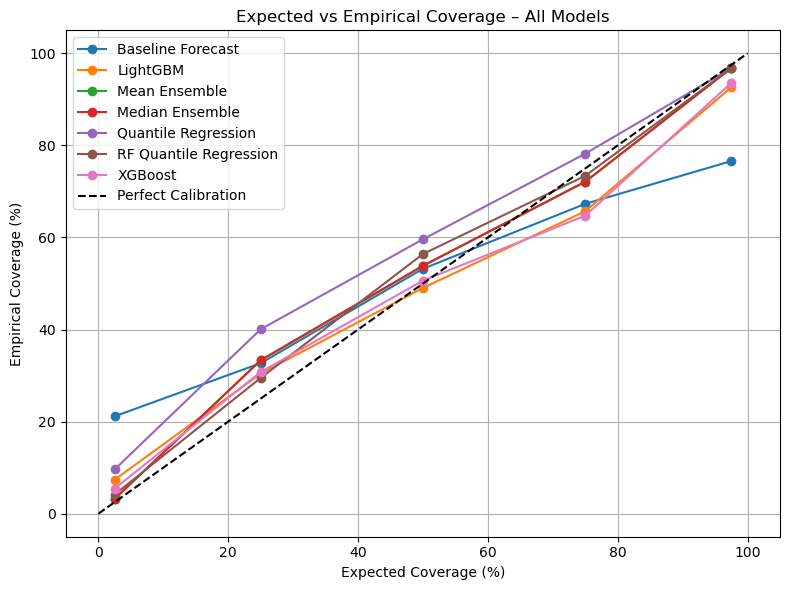

In [11]:
plt.figure(figsize=(8, 6))

# Corrected: multiply by 100 for percentage
expected_coverages = [float(col[1:]) * 100 for col in coverage_summary.columns]

# Plot for each model
for model_name, row in coverage_summary.iterrows():
    plt.plot(expected_coverages, row.values * 100, marker='o', label=model_name)

# Perfect Calibration line
plt.plot([0, 100], [0, 100], linestyle='--', color='black', label="Perfect Calibration")

plt.xlabel("Expected Coverage (%)")
plt.ylabel("Empirical Coverage (%)")
plt.title("Expected vs Empirical Coverage – All Models")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [12]:
expected_coverage = {col: float(col[1:]) for col in coverage_summary.columns}

calibration_deviation = pd.DataFrame(index=coverage_summary.index)

for col in coverage_summary.columns:
    calibration_deviation[col] = expected_coverage[col] - coverage_summary[col]

calibration_deviation = calibration_deviation.round(2)


In [13]:
calibration_deviation

,q0.025,q0.25,q0.5,q0.75,q0.975
Modell,,,,,
Baseline Forecast,-0.19,-0.08,-0.03,0.08,0.21
LightGBM,-0.05,-0.05,0.01,0.09,0.05
Mean Ensemble,-0.01,-0.08,-0.04,0.03,0.01
Median Ensemble,-0.01,-0.08,-0.04,0.03,0.01
Quantile Regression,-0.07,-0.15,-0.10,-0.03,0.01
RF Quantile Regression,-0.02,-0.04,-0.06,0.02,0.01
XGBoost,-0.03,-0.06,-0.01,0.10,0.04


#### Interval Coverage

In [14]:
interval_coverage_rows = []

for model_name, df in results_dict.items():
    lower_95 = df["q0.025"]
    upper_95 = df["q0.975"]
    lower_50 = df["q0.25"]
    upper_50 = df["q0.75"]
    target = df["target"]

    coverage_95 = ((target >= lower_95) & (target <= upper_95)).mean()
    coverage_50 = ((target >= lower_50) & (target <= upper_50)).mean()

    interval_coverage_rows.append({
        "Modell": model_name,
        "CI_50 Coverage": coverage_50,
        "CI_95 Coverage": coverage_95
    })

interval_coverage_df = pd.DataFrame(interval_coverage_rows)
interval_coverage_df = interval_coverage_df.set_index("Modell").round(2)


In [15]:
interval_coverage_df

,CI_50 Coverage,CI_95 Coverage
Modell,,
Baseline Forecast,0.35,0.55
LightGBM,0.35,0.85
Mean Ensemble,0.39,0.94
Median Ensemble,0.39,0.94
Quantile Regression,0.38,0.87
RF Quantile Regression,0.44,0.93
XGBoost,0.34,0.88


#### Quantile Loss and Coverage

In [17]:
quantile_loss_ci_coverage = summary_df.copy()
quantile_loss_ci_coverage = quantile_loss_ci_coverage.join(interval_coverage_df)

In [18]:
quantile_loss_ci_coverage

,q0.025,q0.25,q0.5,q0.75,q0.975,Total Average Loss,CI_50 Coverage,CI_95 Coverage
Model,,,,,,,,
Baseline Forecast,0.66,1.12,1.24,1.01,0.47,4.50,0.35,0.55
Quantile Regression,0.22,0.87,0.96,0.71,0.12,2.88,0.38,0.87
RF Quantile Regression,0.21,0.71,0.88,0.71,0.14,2.64,0.44,0.93
XGBoost,0.17,0.70,0.75,0.62,0.14,2.37,0.34,0.88
LightGBM,0.17,0.69,0.72,0.62,0.14,2.34,0.35,0.85
Mean Ensemble,0.17,0.67,0.77,0.59,0.12,2.33,0.39,0.94
Median Ensemble,0.17,0.67,0.77,0.59,0.12,2.33,0.39,0.94


##### Model Results Visualization

In [19]:
results_dict['Baseline Forecast']

,target,q0.025,q0.25,q0.5,q0.75,q0.975,horizon
Datetime,,,,,,,
2024-02-23 12:00:00+01:00,67.45950,66.348088,68.281625,69.007000,69.211062,69.737056,36
2024-03-01 12:00:00+01:00,65.39850,66.232719,67.127938,68.237875,69.211062,69.737056,36
2024-03-08 12:00:00+01:00,62.52300,65.453606,65.949562,66.796375,67.848688,68.899494,36
2024-03-15 12:00:00+01:00,65.21925,62.738662,64.679625,65.765875,66.464813,67.360031,36
2024-03-22 12:00:00+01:00,64.64900,62.725219,64.545187,65.308875,65.913750,67.304925,36
...,...,...,...,...,...,...,...
2025-01-18 20:00:00+01:00,56.92375,50.997462,53.055875,54.869750,56.351875,57.514562,68
2025-01-25 20:00:00+01:00,53.50225,50.997462,53.055875,55.371000,57.103750,57.589750,68
2025-02-01 20:00:00+01:00,53.89850,53.525950,53.739250,55.371000,57.103750,57.589750,68


C:\Users\Tim Flaschel\AppData\Local\Temp\ipykernel_13056\996301231.py:4: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df = df.loc["2024-11-01":]


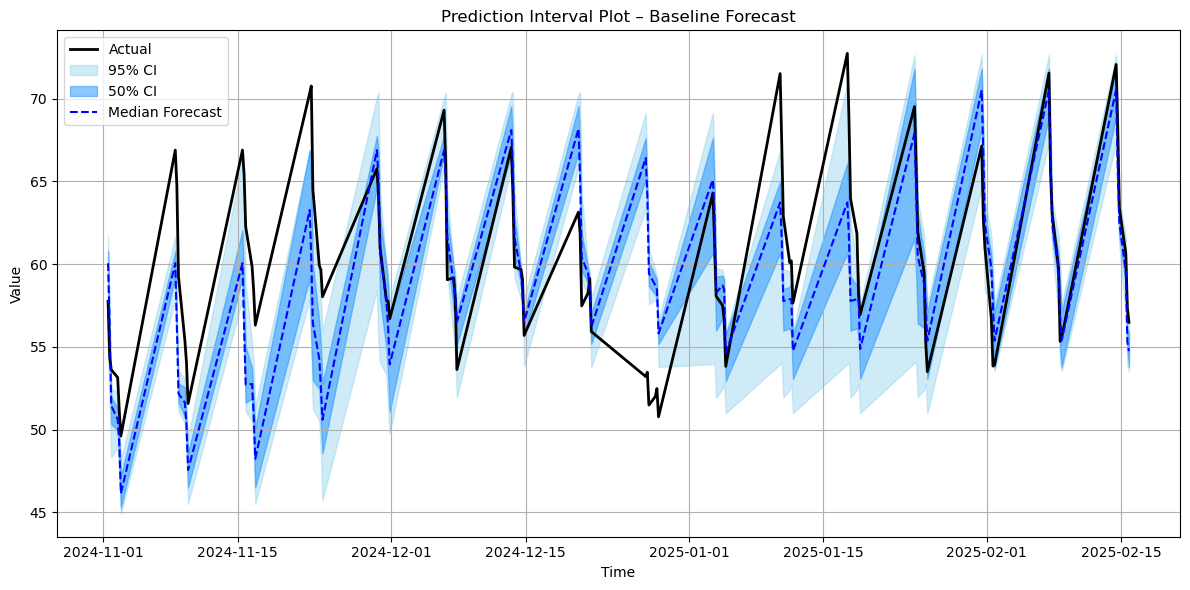

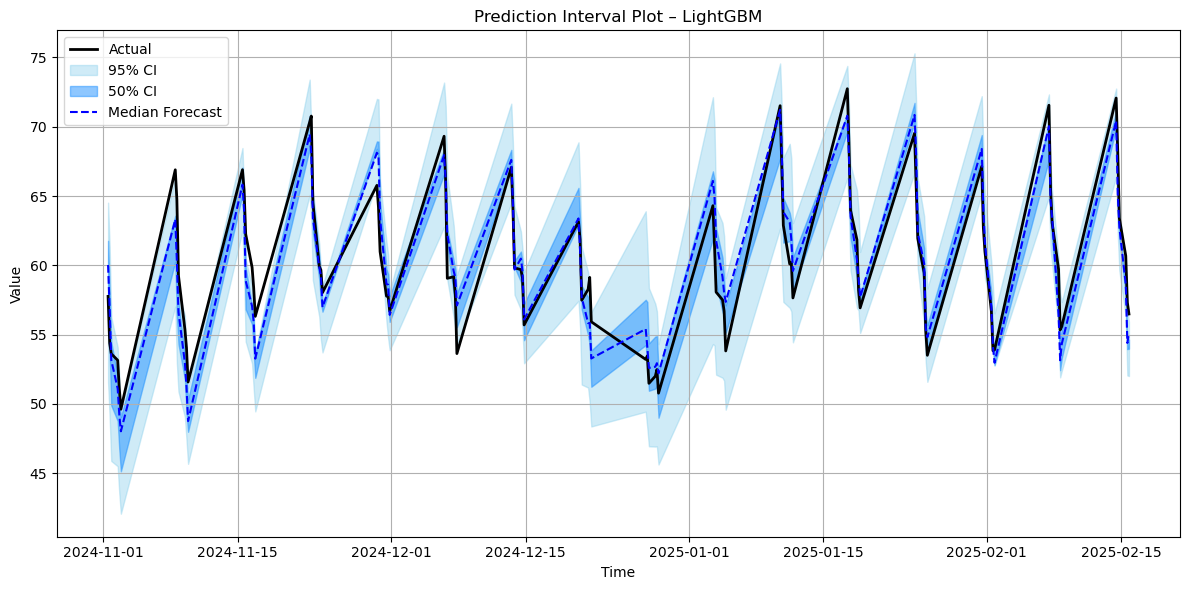

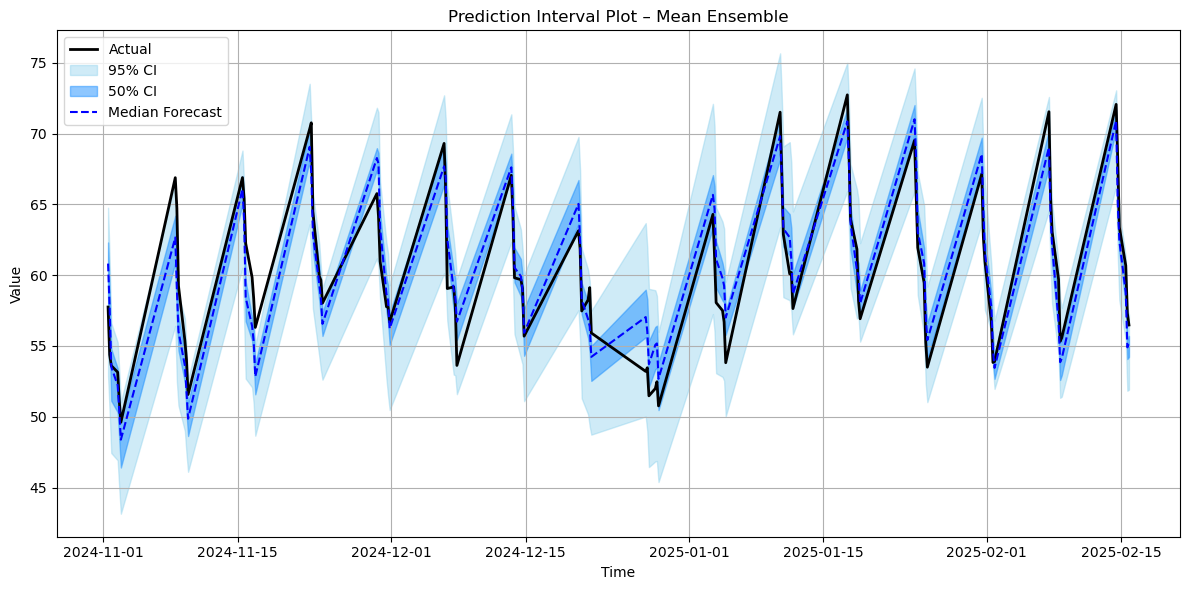

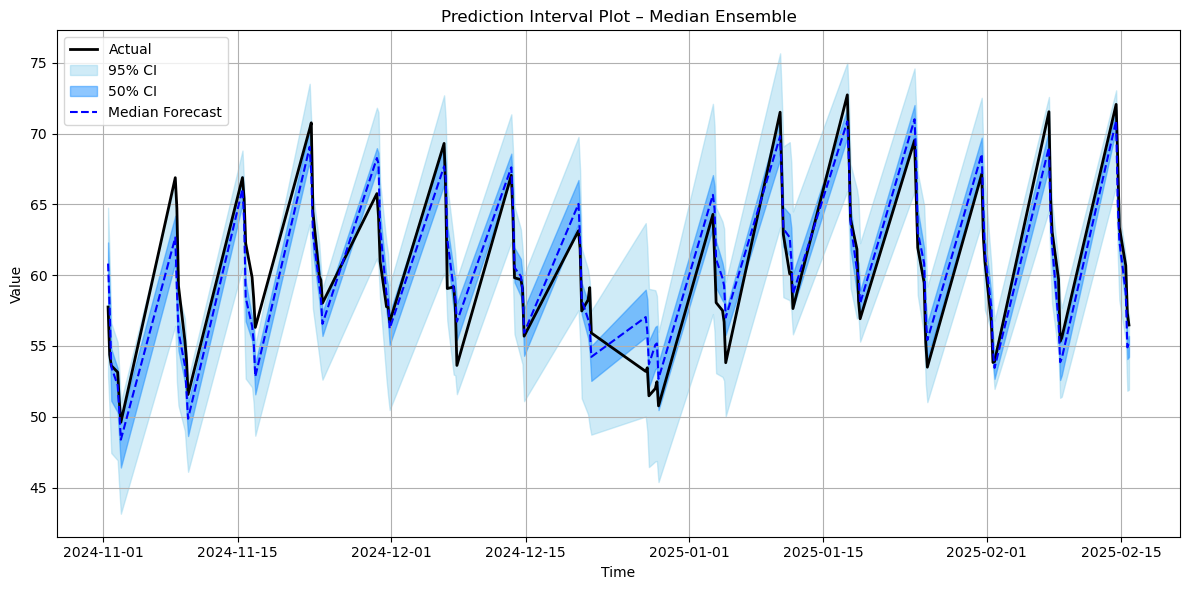

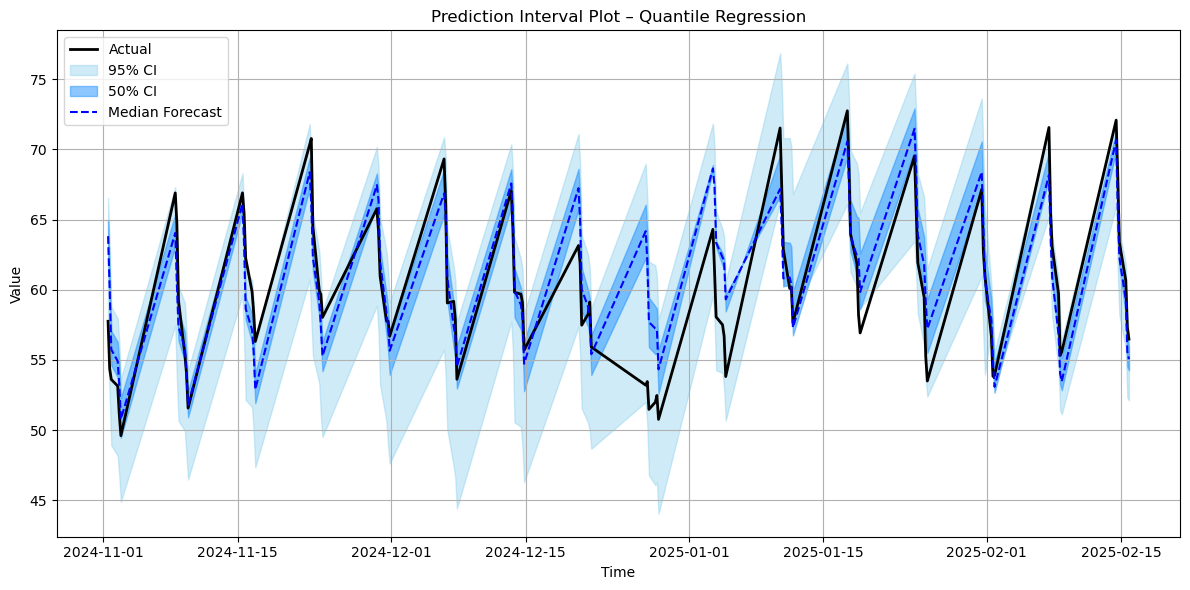

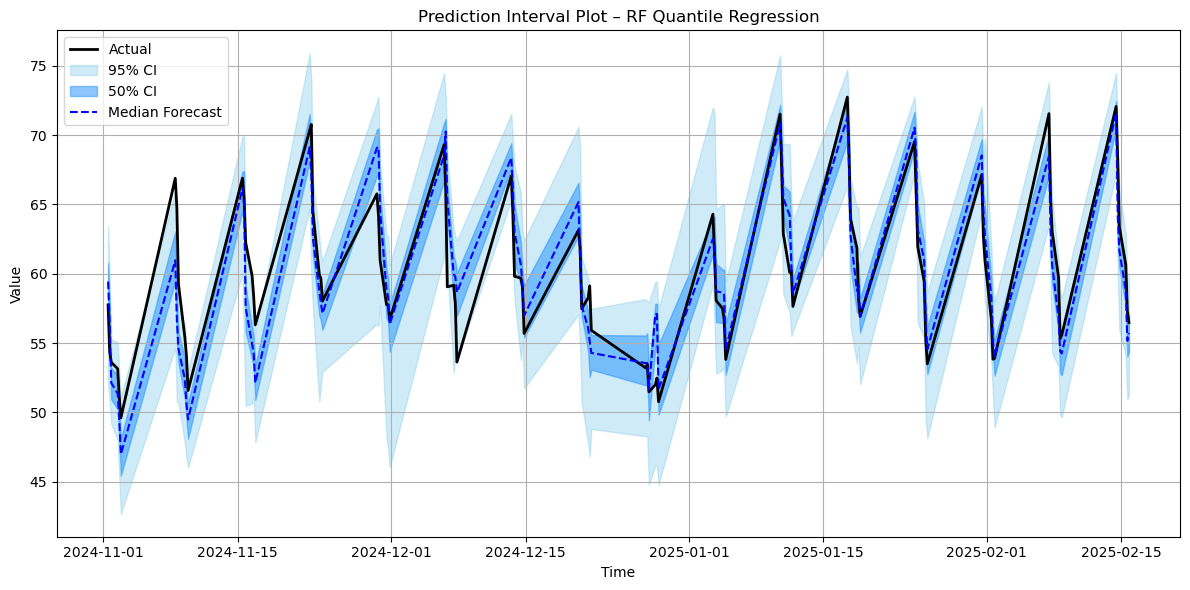

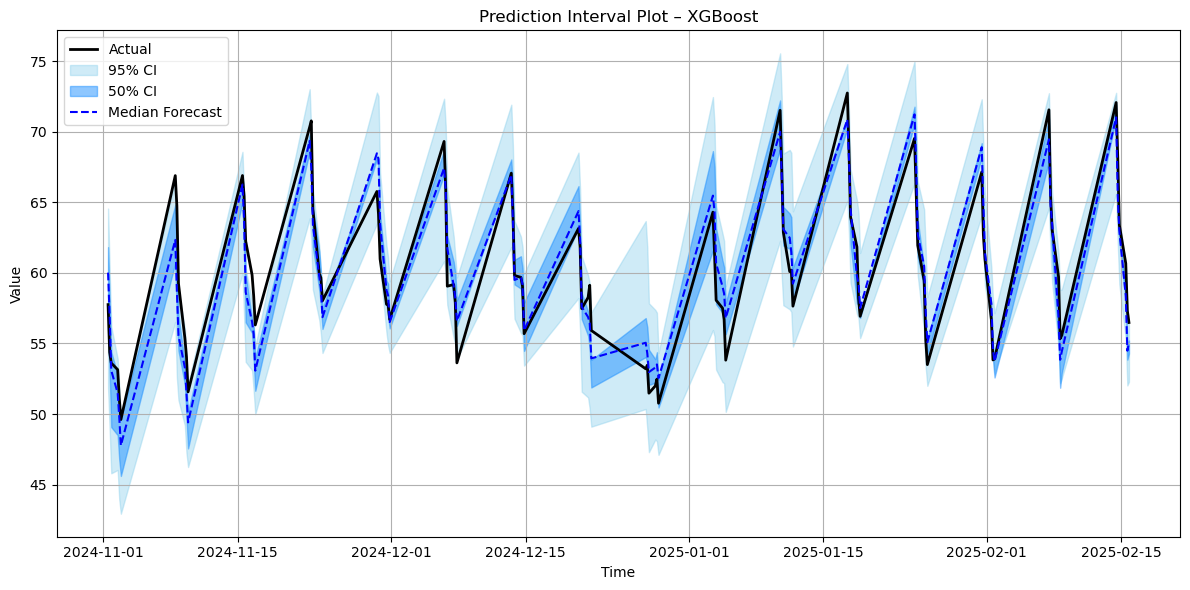

In [20]:
for model_name, df in results_dict.items():
    # Filter by date range
    
    df = df.loc["2024-11-01":]
    plt.figure(figsize=(12, 6))
    df = df.sort_index()
    x = df.index
    y_actual = df["target"]
    q025 = df["q0.025"]
    q975 = df["q0.975"]
    q25 = df["q0.25"]
    q75 = df["q0.75"]
    q50 = df["q0.5"]

    plt.plot(x, y_actual, color="black", label="Actual", linewidth=2)
    plt.fill_between(x, q025, q975, color="skyblue", alpha=0.4, label="95% CI")
    plt.fill_between(x, q25, q75, color="dodgerblue", alpha=0.5, label="50% CI")
    plt.plot(x, q50, color="blue", linestyle="--", label="Median Forecast")

    plt.title(f"Prediction Interval Plot – {model_name}")
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

#### PIT Plots

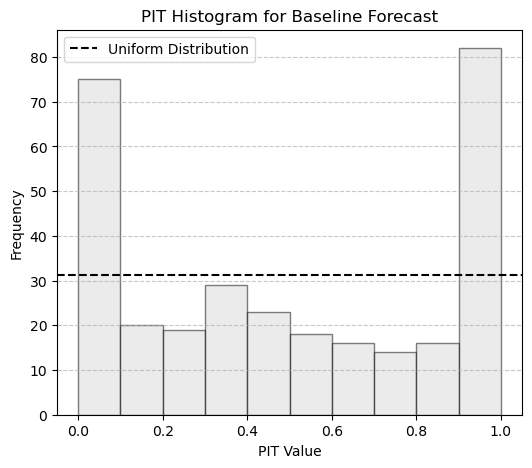

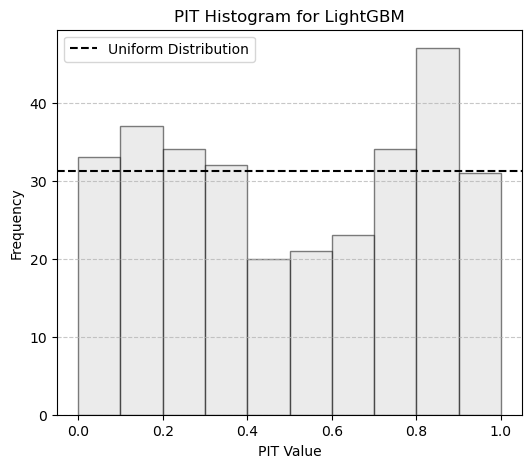

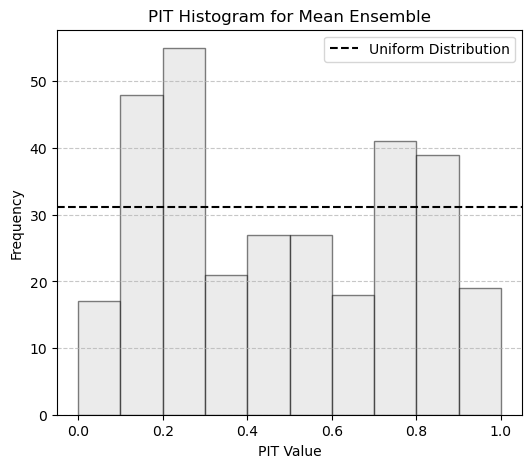

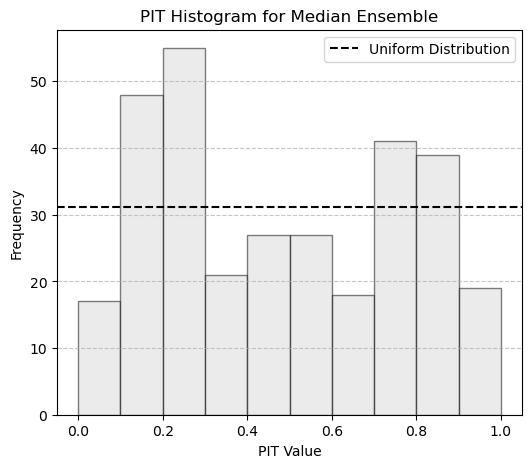

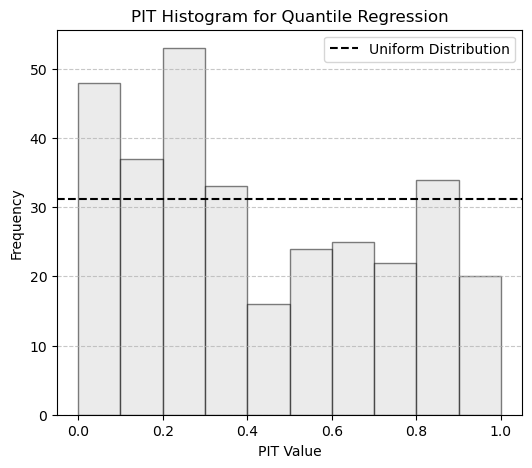

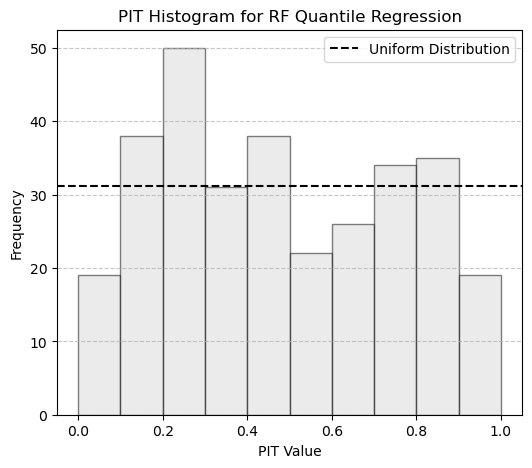

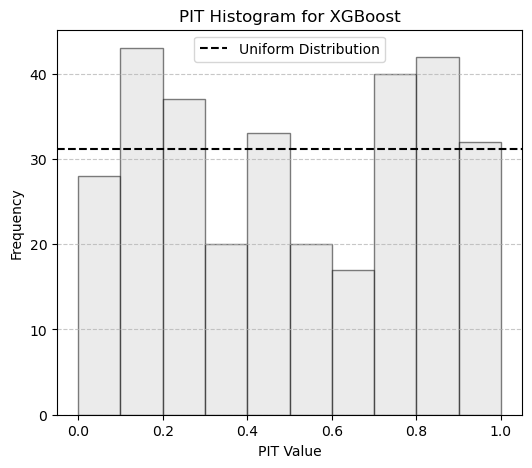

In [16]:
def calculate_pit(row):
    y_target = row['target']
    quantiles = [row['q0.025'], row['q0.25'], row['q0.5'], row['q0.75'], row['q0.975']]
    tau = [0.025, 0.25, 0.5, 0.75, 0.975]
    
    if y_target <= quantiles[0]:
        return 0.0
    
    elif y_target >= quantiles[-1]:
        return 1.0

    for i in range(len(quantiles) - 1):
        if quantiles[i] <= y_target <= quantiles[i + 1]:
            return tau[i] + (y_target - quantiles[i]) / (quantiles[i + 1] - quantiles[i]) * (tau[i + 1] - tau[i])
    return np.nan

def plot_pit_histogram_for_dict(results_dict):
    for model_name, df in results_dict.items():

        df['PIT'] = df.apply(calculate_pit, axis=1)
        
        plt.figure(figsize=(6, 5))
        plt.hist(df['PIT'].dropna(), bins=10, range=(0, 1), edgecolor='black', alpha=0.5, color='#D9D9D9')
        plt.title(f'PIT Histogram for {model_name}')
        plt.xlabel('PIT Value')
        plt.ylabel('Frequency')
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.axhline(y=len(df['PIT']) / 10, color='black', linestyle='--', label='Uniform Distribution')
        plt.legend()
        plt.show()

plot_pit_histogram_for_dict(results_dict)

#### Horizon Results

In [22]:
quantile_loss_dict["Median Ensemble"]

,target,q0.025,q0.25,q0.5,q0.75,q0.975,horizon
Datetime,,,,,,,
2024-02-23 12:00:00+01:00,67.45950,0.098975,0.231282,0.119916,0.263485,0.072343,36
2024-03-01 12:00:00+01:00,65.39850,0.103621,0.159808,0.439110,0.477020,0.086961,36
2024-03-08 12:00:00+01:00,62.52300,0.037472,1.557514,1.513730,1.064223,0.160171,36
2024-03-15 12:00:00+01:00,65.21925,0.127173,0.604432,0.608850,0.178490,0.046647,36
2024-03-22 12:00:00+01:00,64.64900,0.102483,0.409405,0.467757,0.043704,0.049562,36
...,...,...,...,...,...,...,...
2025-01-18 20:00:00+01:00,56.92375,0.040365,0.143932,0.534895,0.489738,0.133532,68
2025-01-25 20:00:00+01:00,53.50225,0.061723,0.428025,0.957453,0.781415,0.142279,68
2025-02-01 20:00:00+01:00,53.89850,0.048217,0.304488,0.223115,0.129552,0.072348,68


In [17]:
horizon_results = {}

for model_name, df in quantile_loss_dict.items():
    quantile_cols = [col for col in df.columns if col.startswith("q")]
    
    grouped = df.groupby("horizon")[quantile_cols].mean()
    grouped = grouped.sort_index()

    # Add total average loss (sum across quantiles per horizon)
    grouped["Total Average Loss"] = grouped.sum(axis=1)

    horizon_results[model_name] = grouped



In [18]:
horizon_results["Median Ensemble"]

,q0.025,q0.25,q0.5,q0.75,q0.975,Total Average Loss
horizon,,,,,,
36,0.249473,0.884761,0.906661,0.637859,0.109122,2.787875
40,0.249744,0.802445,0.887400,0.694566,0.157902,2.792057
44,0.207059,0.687133,0.713086,0.600433,0.144275,2.351986
60,0.131638,0.548552,0.703761,0.565862,0.102267,2.052080
64,0.127707,0.563406,0.732426,0.571032,0.101982,2.096554
68,0.083068,0.541557,0.667034,0.493082,0.101678,1.886419


#### Horizon CI Coverage

In [19]:
results_dict["Median Ensemble"]

,target,q0.025,q0.25,q0.5,q0.75,q0.975,horizon,PIT
Datetime,,,,,,,,
2024-02-23 12:00:00+01:00,67.45950,63.500505,66.534371,67.699331,68.513438,70.353226,36,0.448532
2024-03-01 12:00:00+01:00,65.39850,61.253650,65.611577,66.276721,67.306581,68.876923,36,0.238999
2024-03-08 12:00:00+01:00,62.52300,61.024124,64.599686,65.550461,66.779890,68.929856,36,0.119320
2024-03-15 12:00:00+01:00,65.21925,60.132342,62.801520,64.001550,64.981264,67.085121,36,0.775452
2024-03-22 12:00:00+01:00,64.64900,60.549664,63.011381,63.713485,64.823816,66.631490,36,0.710639
...,...,...,...,...,...,...,...,...
2025-01-18 20:00:00+01:00,56.92375,55.309151,57.115659,57.993541,58.882703,62.265011,68,0.226098
2025-01-25 20:00:00+01:00,53.50225,51.033313,54.072950,55.417155,56.627908,59.193421,68,0.207756
2025-02-01 20:00:00+01:00,53.89850,51.969816,52.680547,53.452270,54.416709,56.792425,68,0.615671


In [20]:
horizon_coverage = {}

for model_name, df in results_dict.items():
    # Boolean Series: whether target lies within CI bounds
    ci_95 = (df["target"] >= df["q0.025"]) & (df["target"] <= df["q0.975"])
    ci_50 = (df["target"] >= df["q0.25"]) & (df["target"] <= df["q0.75"])

    # Calculate interval widths
    df["CI_95_Width"] = df["q0.975"] - df["q0.025"]
    df["CI_50_Width"] = df["q0.75"] - df["q0.25"]

    # Add coverage to DataFrame temporarily
    df_temp = df.copy()
    df_temp["CI_95_Coverage"] = ci_95.astype(int)
    df_temp["CI_50_Coverage"] = ci_50.astype(int)

    # Group by horizon and calculate mean values
    grouped = df_temp.groupby("horizon")[
        ["CI_50_Coverage", "CI_95_Coverage", "CI_50_Width", "CI_95_Width"]
    ].mean()

    grouped = grouped.rename(columns={
        "CI_50_Coverage": "CI_50 Coverage",
        "CI_95_Coverage": "CI_95 Coverage",
        "CI_50_Width": "CI_50 Width",
        "CI_95_Width": "CI_95 Width"
    })

    horizon_coverage[model_name] = grouped.round(3)



In [21]:
horizon_coverage["Median Ensemble"]

,CI_50 Coverage,CI_95 Coverage,CI_50 Width,CI_95 Width
horizon,,,,
36,0.404,0.942,2.331,8.854
40,0.404,0.885,2.311,8.655
44,0.423,0.885,2.106,7.822
60,0.385,0.962,2.033,7.183
64,0.346,0.962,2.040,6.919
68,0.365,0.981,1.961,6.413


In [22]:
horizon_summary = {}

for model_name in horizon_results:
    df_loss = horizon_results[model_name]
    df_cov = horizon_coverage.get(model_name)

    if df_cov is not None:
        # Combine both DataFrames on the horizon index
        combined = df_loss.join(df_cov)
        horizon_summary[model_name] = combined

In [23]:
horizon_summary["XGBoost"].round(2)

,q0.025,q0.25,q0.5,q0.75,q0.975,Total Average Loss,CI_50 Coverage,CI_95 Coverage,CI_50 Width,CI_95 Width
horizon,,,,,,,,,,
36,0.24,0.94,0.90,0.67,0.11,2.85,0.31,0.92,2.09,8.89
40,0.22,0.85,0.83,0.68,0.18,2.76,0.38,0.86,2.10,8.54
44,0.19,0.73,0.68,0.56,0.16,2.32,0.36,0.88,1.86,7.48
60,0.14,0.57,0.71,0.63,0.14,2.19,0.35,0.86,1.60,6.20
64,0.16,0.55,0.73,0.62,0.12,2.18,0.33,0.85,1.58,5.84
68,0.08,0.55,0.65,0.53,0.11,1.92,0.31,0.90,1.62,5.53


In [24]:
horizon_summary["LightGBM"].round(2)

,q0.025,q0.25,q0.5,q0.75,q0.975,Total Average Loss,CI_50 Coverage,CI_95 Coverage,CI_50 Width,CI_95 Width
horizon,,,,,,,,,,
36,0.21,0.90,0.82,0.72,0.11,2.76,0.35,0.92,2.21,8.56
40,0.24,0.81,0.83,0.66,0.18,2.72,0.40,0.83,2.07,8.28
44,0.19,0.71,0.69,0.54,0.16,2.28,0.38,0.86,1.72,7.21
60,0.15,0.59,0.66,0.63,0.15,2.18,0.36,0.83,1.66,6.05
64,0.16,0.57,0.68,0.64,0.14,2.19,0.33,0.83,1.61,5.80
68,0.09,0.53,0.64,0.51,0.13,1.90,0.29,0.85,1.68,5.38


In [25]:
horizon_summary["Quantile Regression"].round(2)

,q0.025,q0.25,q0.5,q0.75,q0.975,Total Average Loss,CI_50 Coverage,CI_95 Coverage,CI_50 Width,CI_95 Width
horizon,,,,,,,,,,
36,0.31,1.13,1.18,0.79,0.10,3.50,0.31,0.88,2.27,8.62
40,0.27,1.00,1.10,0.83,0.17,3.37,0.36,0.88,2.43,8.78
44,0.25,0.86,0.94,0.74,0.14,2.92,0.38,0.88,2.18,7.76
60,0.15,0.65,0.78,0.62,0.11,2.31,0.42,0.90,2.33,7.98
64,0.20,0.79,0.88,0.64,0.11,2.62,0.46,0.86,2.52,8.14
68,0.17,0.78,0.88,0.66,0.09,2.58,0.35,0.81,2.14,6.90


In [26]:
horizon_summary["RF Quantile Regression"].round(2)

,q0.025,q0.25,q0.5,q0.75,q0.975,Total Average Loss,CI_50 Coverage,CI_95 Coverage,CI_50 Width,CI_95 Width
horizon,,,,,,,,,,
36,0.26,0.81,0.94,0.73,0.14,2.88,0.48,0.92,2.75,9.36
40,0.32,0.87,1.03,0.84,0.20,3.26,0.40,0.92,2.64,9.02
44,0.25,0.79,0.92,0.72,0.15,2.84,0.44,0.90,2.66,8.83
60,0.16,0.61,0.87,0.69,0.13,2.45,0.40,0.92,2.54,8.50
64,0.15,0.60,0.81,0.67,0.11,2.33,0.44,0.94,2.44,7.89
68,0.12,0.57,0.70,0.59,0.10,2.08,0.46,0.94,2.41,7.84
